In [1]:
# supress unnecessary warnings so the notebook looks clean
import warnings
warnings.filterwarnings('ignore')

# import libraries to quickly analyze data
import numpy as np
import pandas as pd
pd.set_option('precision', 4)

# import plotting libraries
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# let's get and put the data in pandas dataframe
order_products_train = pd.read_csv('datasets/order_products__train.csv')
order_products_prior = pd.read_csv('datasets/order_products__prior.csv')
orders = pd.read_csv('datasets/orders.csv')
products = pd.read_csv('datasets/products.csv')
aisles = pd.read_csv('datasets/aisles.csv')
departments = pd.read_csv('datasets/departments.csv')

## Data Analysis

### 1. order_products_train and order_products_prior

Firstly, let's explore order_products_train and order_products_prior files. These files specify which products were purchased in each order. More specifically, order_products__prior contains previous order contents for all customers and order_products_train contains the last orders for some customers only.

In [3]:
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)

# let's concatenate them in the same order_products dataframe
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)
print("The order_products_all size is : ", order_products_all.shape)

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)
The order_products_all size is :  (33819106, 4)


In [4]:
# there is no missing data in order_products_all dataset
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
reordered,0,0.0
add_to_cart_order,0,0.0
product_id,0,0.0
order_id,0,0.0


In [5]:
# check the number of unique orders and unique products
orders_Unique = len(set(order_products_all.order_id))
products_Unique = len(set(order_products_all.product_id))
print("There are %s orders for %s products" %(orders_Unique, products_Unique))

There are 3346083 orders for 49685 products


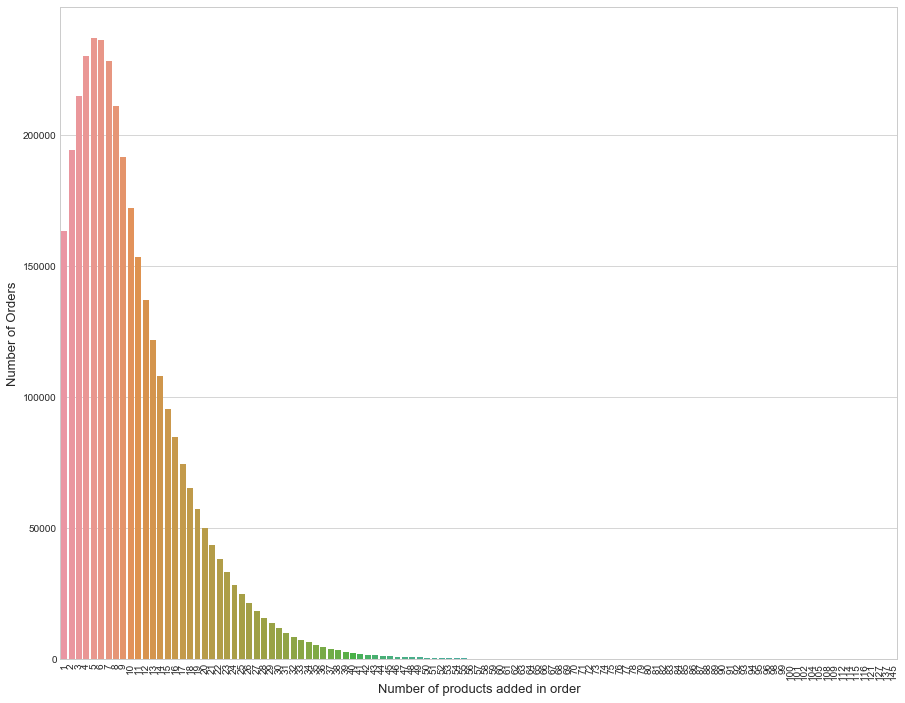

In [6]:
# number of products that people usually order

grouped = order_products_all.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped = grouped.add_to_cart_order.value_counts()

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)

plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()

We can observe that people usually order around 5 products.

In [7]:
# which products are ordered the most
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'count'}).reset_index()
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped.sort_values(by='Total_reorders', ascending=False)[:10]
grouped

,product_id,Total_reorders,product_name
24849,24852,491291,Banana
13173,13176,394930,Bag of Organic Bananas
21134,21137,275577,Organic Strawberries
21900,21903,251705,Organic Baby Spinach
47205,47209,220877,Organic Hass Avocado
47762,47766,184224,Organic Avocado
47622,47626,160792,Large Lemon
16794,16797,149445,Strawberries
26206,26209,146660,Limes
27842,27845,142813,Organic Whole Milk


Fruits like banana , strawberries...are the most ordered products.

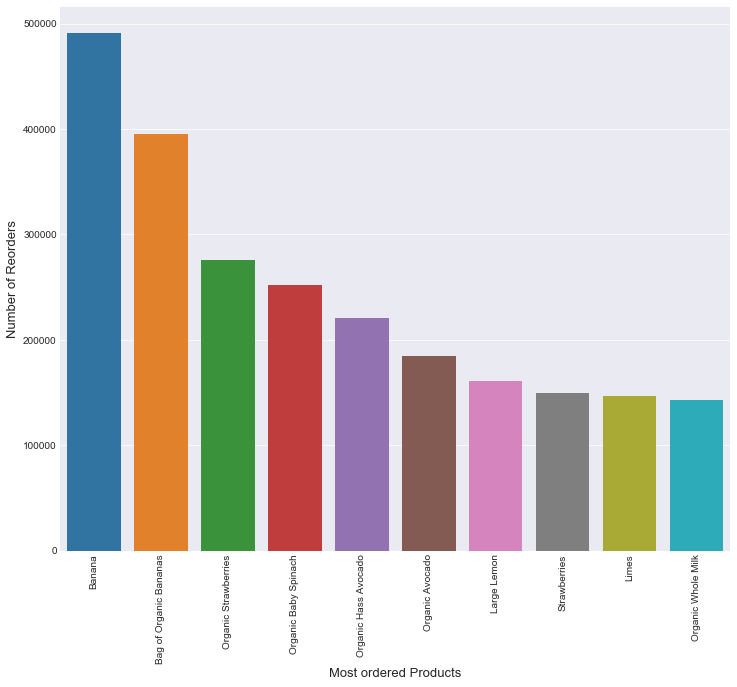

In [8]:
grouped  = grouped.groupby(['product_name']).sum()['Total_reorders'].sort_values(ascending=False)
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Reorders', fontsize=13)
plt.xlabel('Most ordered Products', fontsize=13)
plt.show()

In [9]:
# do people usually reorder the same previous ordered products
grouped = order_products_all.groupby("reordered")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped

,reordered,Total_products,Ratios
0,0,13863746,0.4099
1,1,19955360,0.5901


59 % of ordered products are previously ordered by customers.

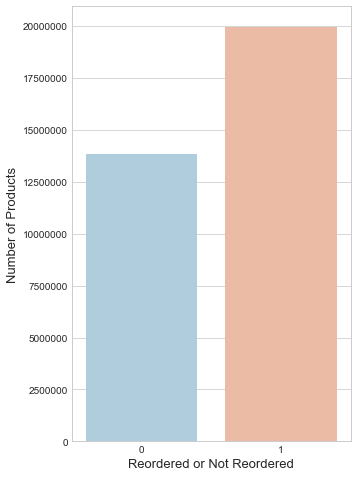

In [10]:
grouped  = grouped.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(grouped.index, grouped.values, palette='RdBu_r')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered or Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [11]:
# which products are usually reordered
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,
                                'reorder_total': 'count'}).reset_index()
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped[grouped.reorder_total > 75].sort_values(['reorder_probability'], ascending=False)[:10]
grouped

,product_id,reorder_sum,reorder_total,reorder_probability,product_name
2074,2075,84,90,0.9333,Serenity Ultimate Extrema Overnight Pads
27737,27740,94,102,0.9216,Chocolate Love Bar
35601,35604,93,104,0.8942,Maca Buttercups
38248,38251,99,111,0.8919,Benchbreak Chardonnay
36798,36801,88,99,0.8889,Organic Blueberry B Mega
10233,10236,114,131,0.8702,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,99,114,0.8684,Thousand Island Salad Snax
5455,5457,78,90,0.8667,Classic Carbonated Natural Mineral Water
35493,35496,394,457,0.8621,Real2 Alkalized Water 500 ml
9289,9292,2580,2995,0.8614,Half And Half Ultra Pasteurized


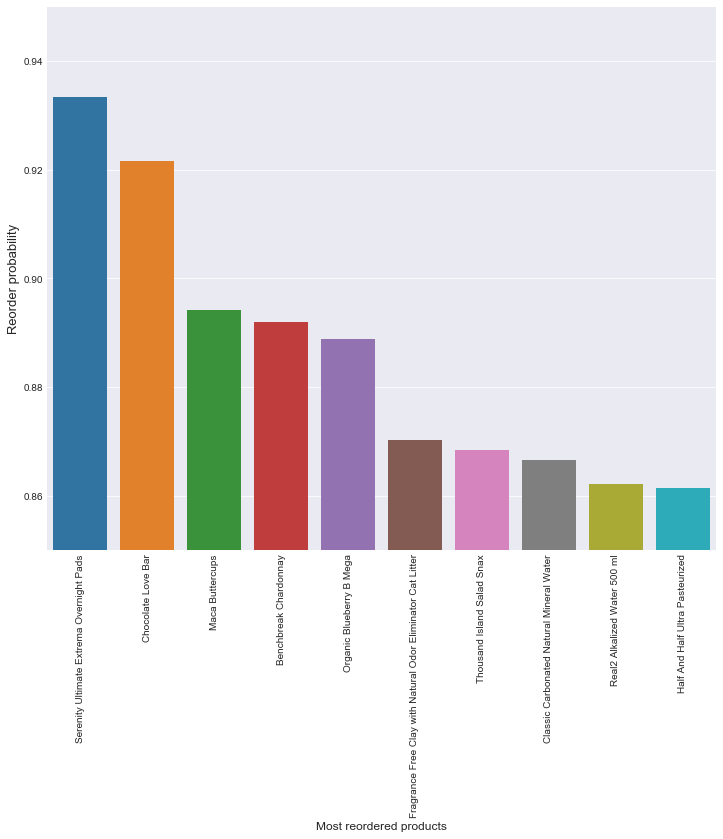

In [12]:
grouped  = grouped.groupby(['product_name']).sum()['reorder_probability'].sort_values(ascending=False)
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylim([0.85,0.95])
plt.ylabel('Reorder probability', fontsize=13)
plt.xlabel('Most reordered products', fontsize=12)
plt.show()

del grouped

### 2. orders

In [13]:
print("The orders data size is : ", orders.shape)
orders.head()

The orders data size is :  (3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [14]:
# missing values
orders_na = (orders.isnull().sum() / len(orders)) * 100
orders_na = orders_na.drop(orders_na[orders_na == 0].index).sort_values(ascending=False)
orders_na

days_since_prior_order    6.0276
dtype: float64

The only feature with missing values is days_since_prior_order with 6.028 % missing.

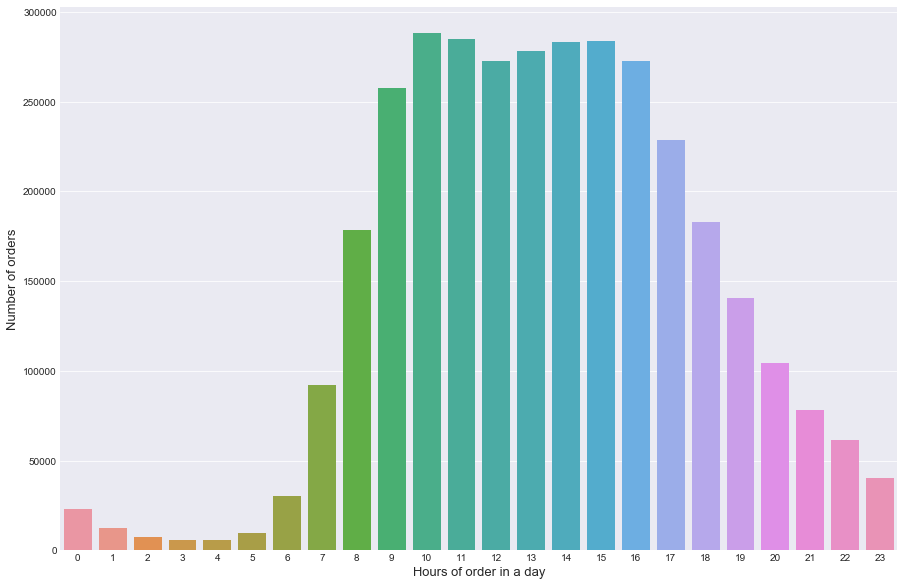

In [15]:
# hours of order in a day

grouped = orders.groupby("order_id")["order_hour_of_day"].aggregate("sum").reset_index()
grouped = grouped.order_hour_of_day.value_counts()

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Hours of order in a day', fontsize=13)
plt.show()

People mostly order between 8 and 19 (anonimyzed hours and probably between 8 a.m and 7 p.m.).

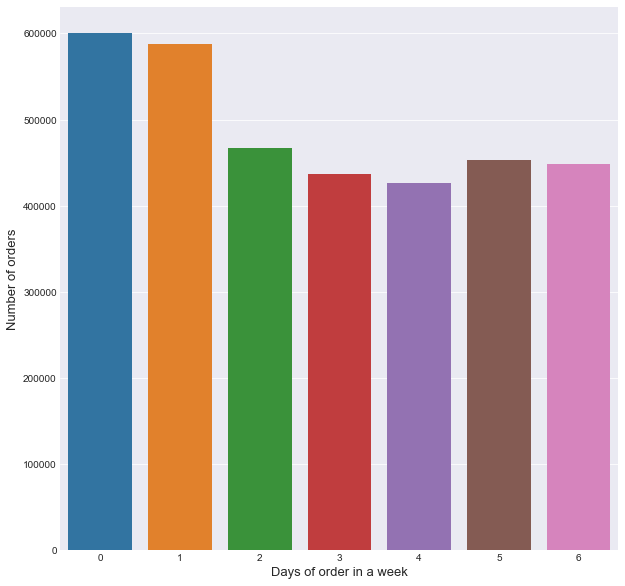

In [16]:
# days of orders in a week

grouped = orders.groupby("order_id")["order_dow"].aggregate("sum").reset_index()
grouped = grouped.order_dow.value_counts()

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Days of order in a week', fontsize=13)
plt.show()

People usually order at days 0 and 1 (anonimyzed days and probably the week end).

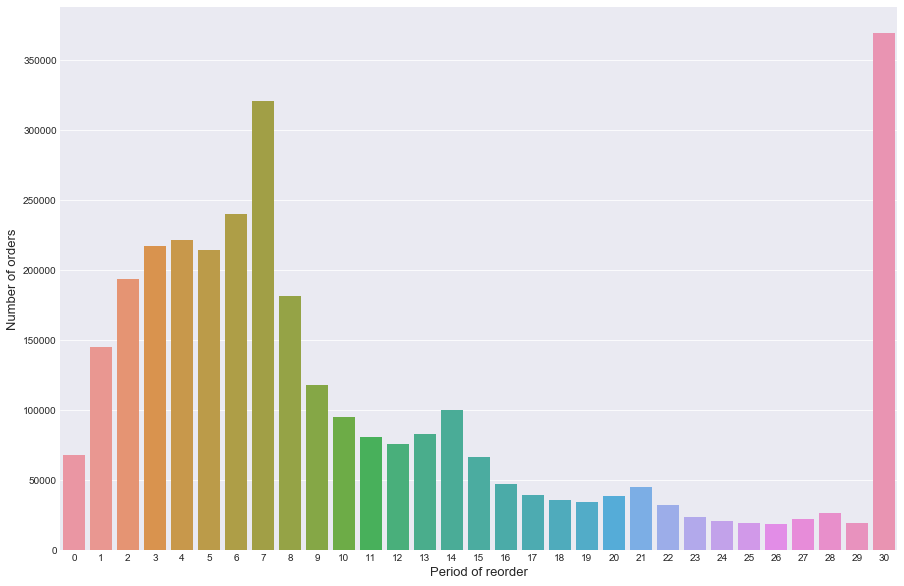

In [17]:
# period of reorders

grouped = orders.groupby("order_id")["days_since_prior_order"].aggregate("sum").reset_index()
grouped = grouped.days_since_prior_order.value_counts()

f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Period of reorder', fontsize=13)
plt.show()

People usually reorder either after 1 week or after 1 month.

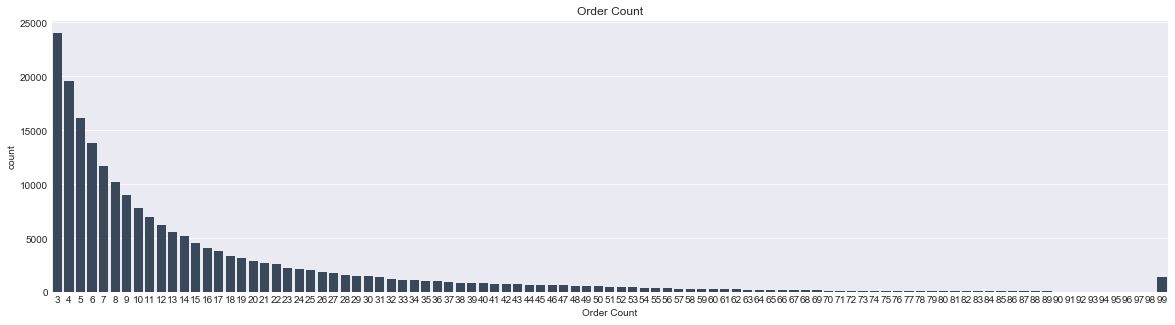

In [18]:
# how many orders users generally made
orderCount = orders[orders["eval_set"]=="prior"].groupby(by=["user_id"])["order_id"].count().to_frame()
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.countplot(color="#34495e",data=orderCount,x="order_id",ax=ax)
ax.set(xlabel='Order Count',title="Order Count")

del grouped, orderCount

### 3. order_products_train, order_products_prior and orders

In [19]:
# number and ratio of orders from the three datasets
grouped = orders.groupby("eval_set")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped

,eval_set,Total_orders,Ratio
0,prior,3214874,0.9397
1,test,75000,0.0219
2,train,131209,0.0384


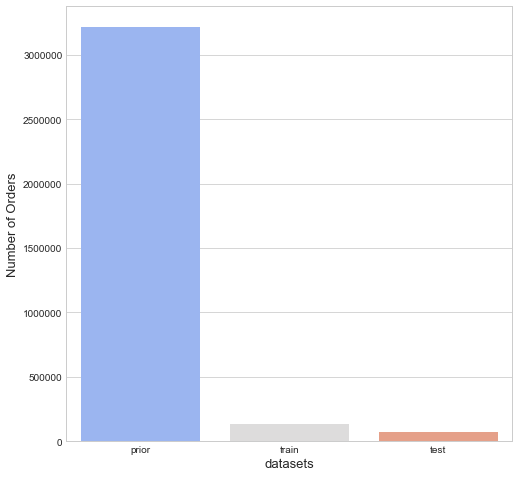

In [20]:
grouped  = grouped.groupby(['eval_set']).sum()['Total_orders'].sort_values(ascending=False)
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(grouped.index, grouped.values, palette='coolwarm')
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('datasets', fontsize=13)
plt.show()

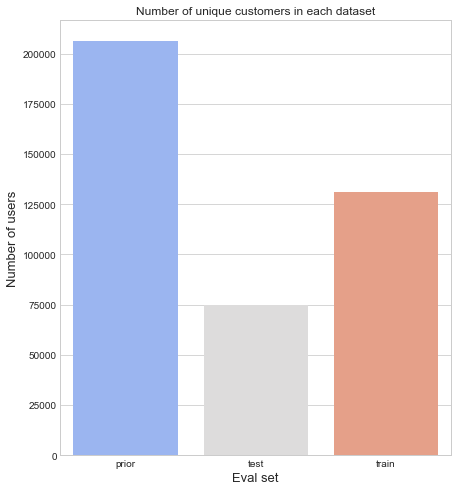

In [21]:
# check the number of unique customers in the three datasets

grouped = orders.groupby("eval_set")["user_id"].apply(lambda x: len(x.unique()))
plt.figure(figsize=(7,8))
sns.barplot(grouped.index, grouped.values, palette='coolwarm')
plt.ylabel('Number of users', fontsize=13)
plt.xlabel('Eval set', fontsize=13)
plt.title("Number of unique customers in each dataset")
plt.show()

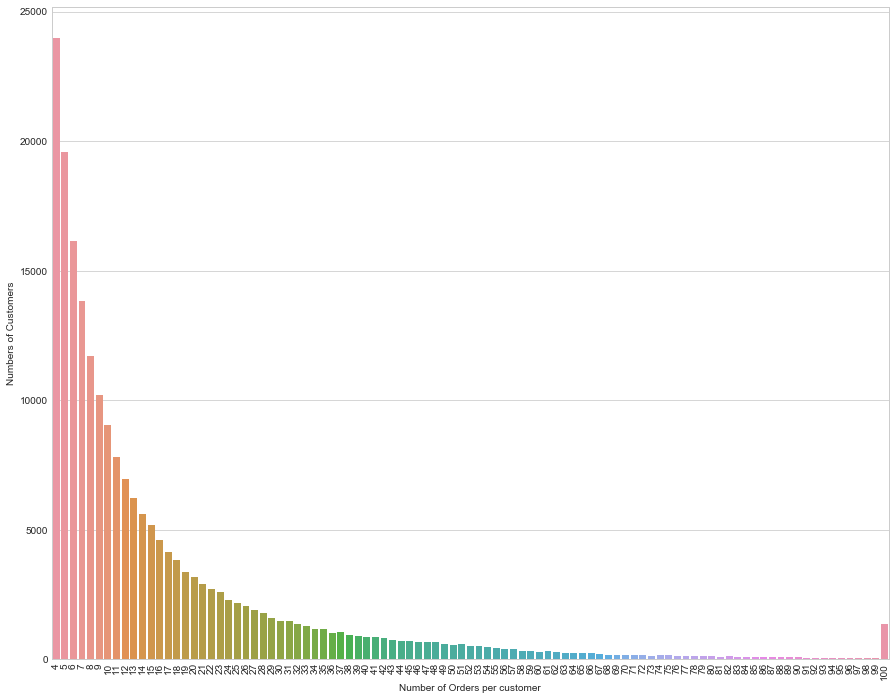

In [22]:
# check the number of orders made by each costumer in the whole dataset

grouped = orders.groupby('user_id')['order_id'].apply(lambda x: len(x.unique())).reset_index()
grouped = grouped.groupby('order_id').aggregate("count")

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(15, 12))
sns.barplot(grouped.index, grouped.user_id)
plt.ylabel('Numbers of Customers')
plt.xlabel('Number of Orders per customer')
plt.xticks(rotation='vertical')
plt.show()

del grouped

We can observe that most customers made 4 orders.

### 4. products, departments and aisles

In [23]:
items  = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
items.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [24]:
# the most important departments (by number of products)
grouped = items.groupby("department")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
grouped

,department,Total_products,Ratio
17,personal care,6563,0.1321
20,snacks,6264,0.1261
16,pantry,5371,0.1081
3,beverages,4365,0.0878
10,frozen,4007,0.0806
7,dairy eggs,3449,0.0694
11,household,3085,0.0621
6,canned goods,2092,0.0421
9,dry goods pasta,1858,0.0374
19,produce,1684,0.0339


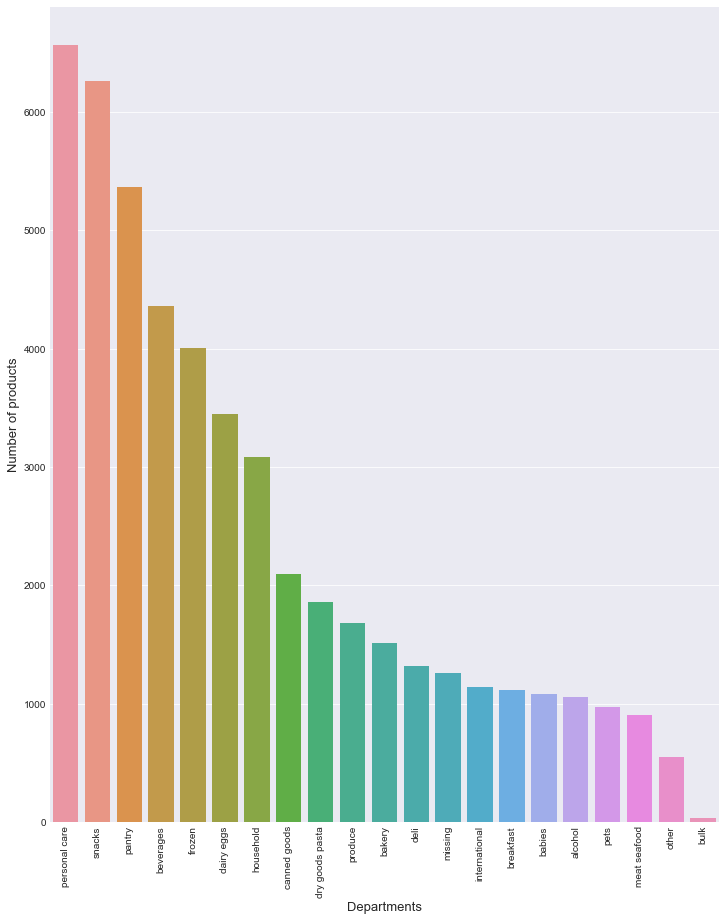

In [25]:
grouped  = grouped.groupby(['department']).sum()['Total_products'].sort_values(ascending=False)
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

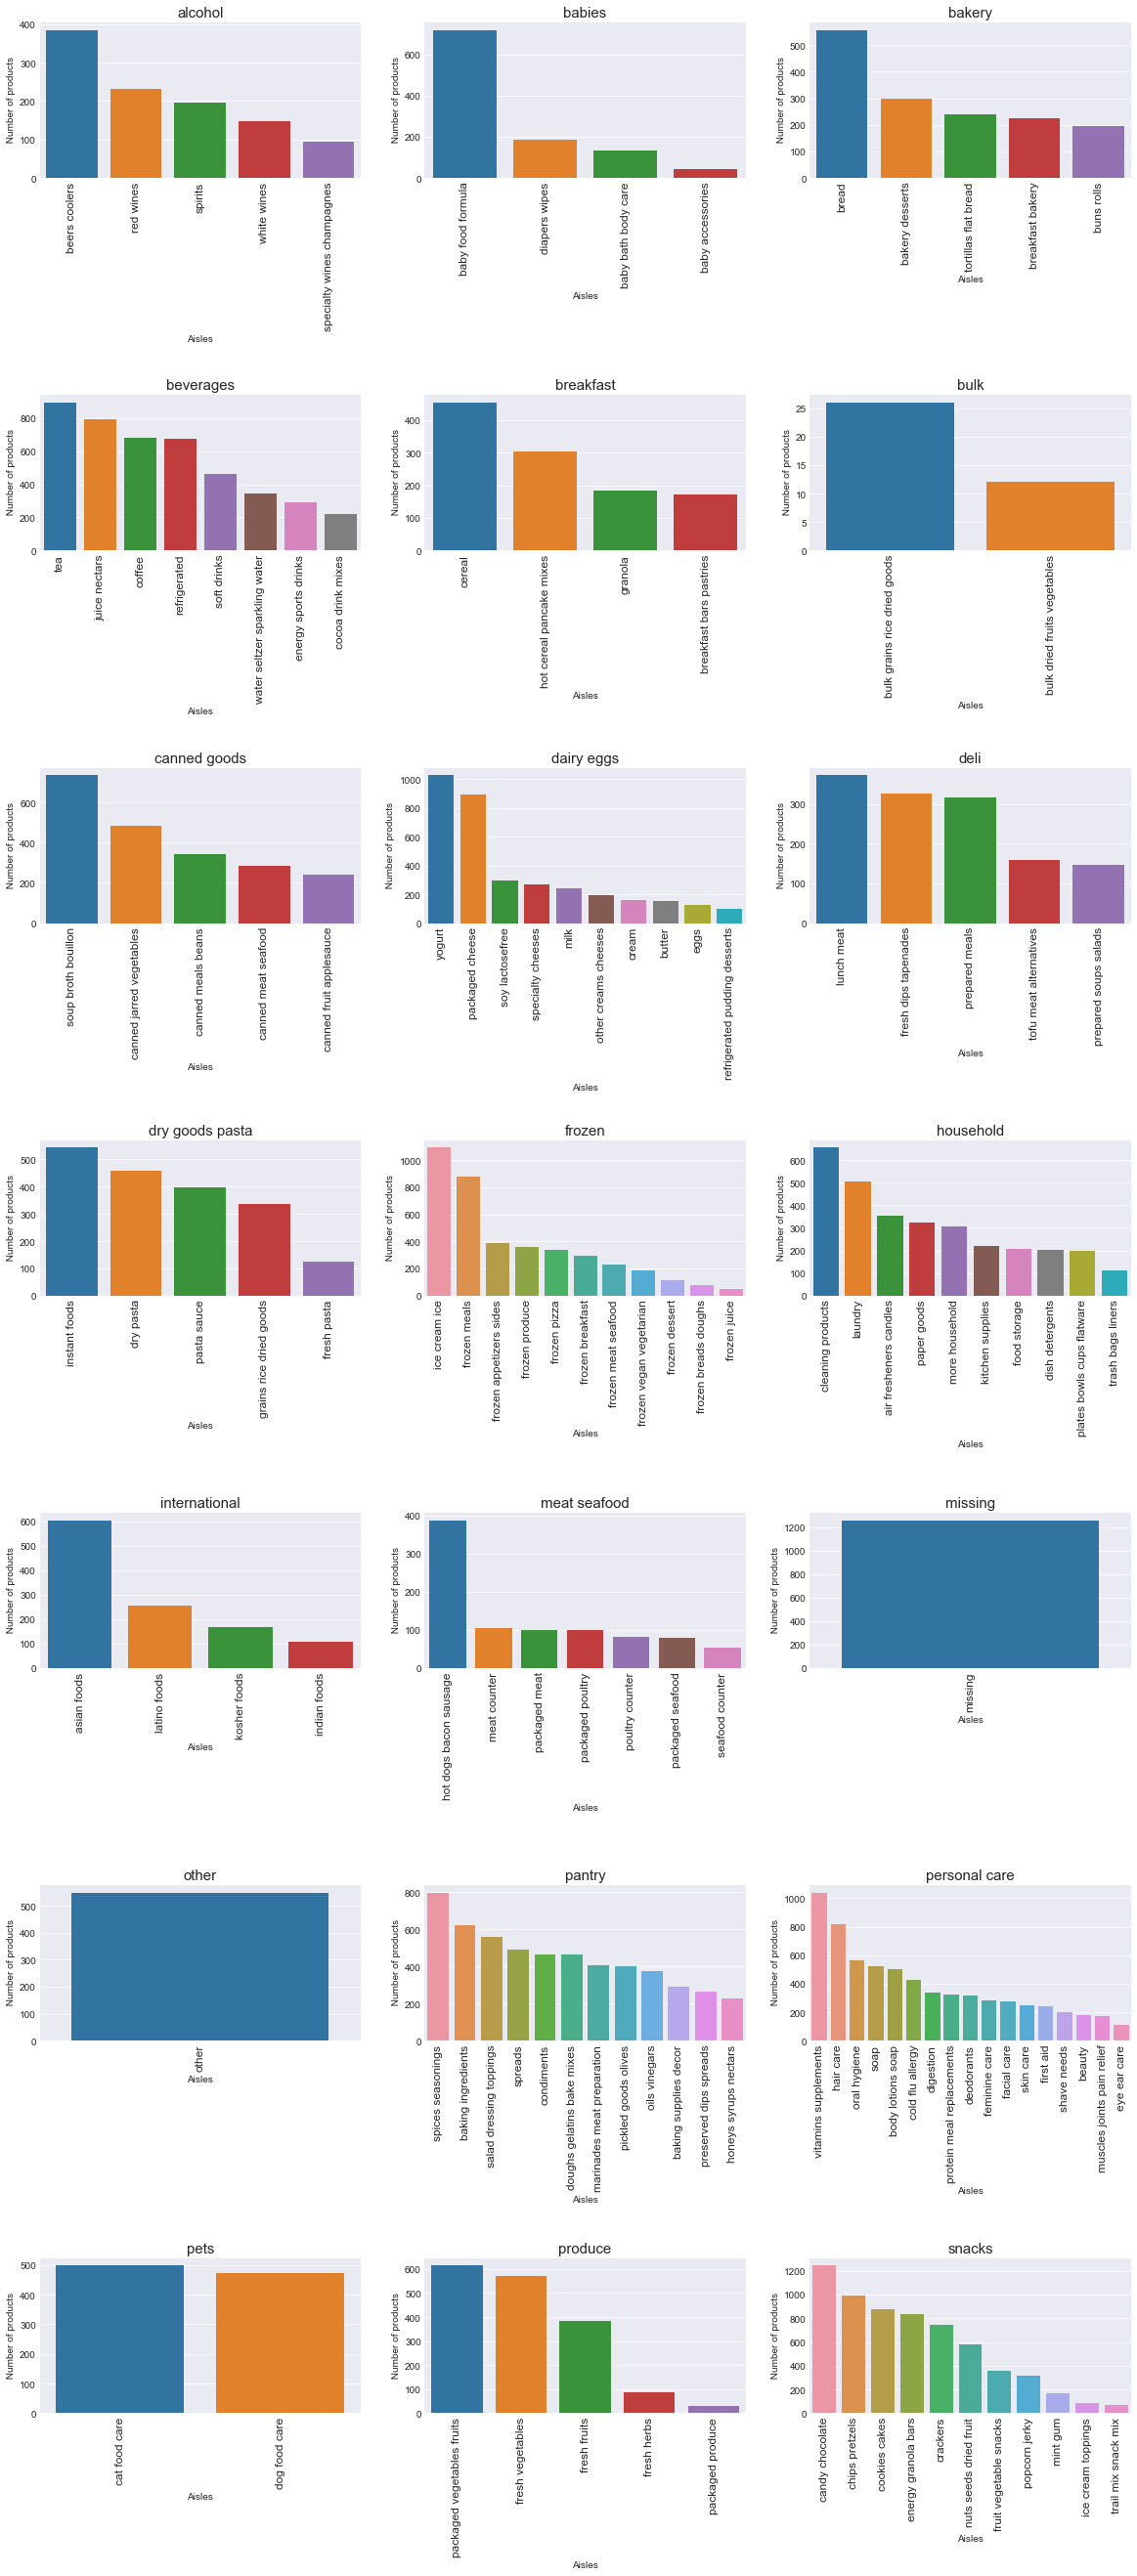

In [26]:
# the most important aisles in each department (by number of products)

grouped = items.groupby(["department", "aisle"])["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped.sort_values(by='Total_products', ascending=False, inplace=True)

fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_products , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

In [27]:
# the most important aisles over all departments (by number of products)
grouped = items.groupby("aisle")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped = grouped.sort_values(by='Total_products', ascending=False)[:20]
grouped

,aisle,Total_products,Ratio
85,missing,1258,0.0253
18,candy chocolate,1246,0.0251
71,ice cream ice,1091,0.0220
130,vitamins supplements,1038,0.0209
133,yogurt,1026,0.0206
25,chips pretzels,989,0.0199
125,tea,894,0.0180
93,packaged cheese,891,0.0179
59,frozen meals,880,0.0177
31,cookies cakes,874,0.0176


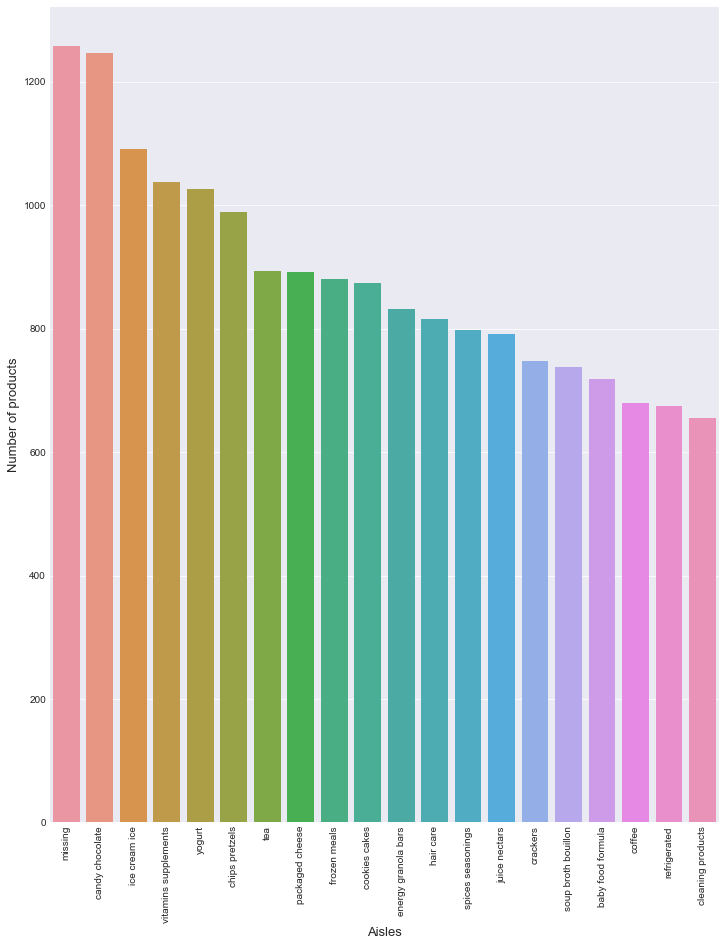

In [28]:
grouped  = grouped.groupby(['aisle']).sum()['Total_products'].sort_values(ascending=False)
f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()

In [29]:
# what are customers' favorite departments and aisles
users_flow = orders[['user_id', 'order_id']].merge(order_products_train[['order_id', 'product_id']],
                                             how='inner', left_on='order_id', right_on='order_id')
users_flow = users_flow.merge(items, how='inner', left_on='product_id', right_on='product_id')
users_flow.head()

,user_id,order_id,product_id,product_name,aisle_id,department_id,department,aisle
0,1,1187899,196,Soda,77,7,beverages,soft drinks
1,67,2757217,196,Soda,77,7,beverages,soft drinks
2,676,632715,196,Soda,77,7,beverages,soft drinks
3,760,1167274,196,Soda,77,7,beverages,soft drinks
4,804,3347074,196,Soda,77,7,beverages,soft drinks


In [30]:
# the best selling departments (number of orders)
grouped = users_flow.groupby("department")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
grouped

,department,Total_orders,Ratio
19,produce,409087,0.2955
7,dairy eggs,217051,0.1568
20,snacks,118862,0.0858
3,beverages,114046,0.0824
10,frozen,100426,0.0725
16,pantry,81242,0.0587
2,bakery,48394,0.0350
6,canned goods,46799,0.0338
8,deli,44291,0.0320
9,dry goods pasta,38713,0.0280


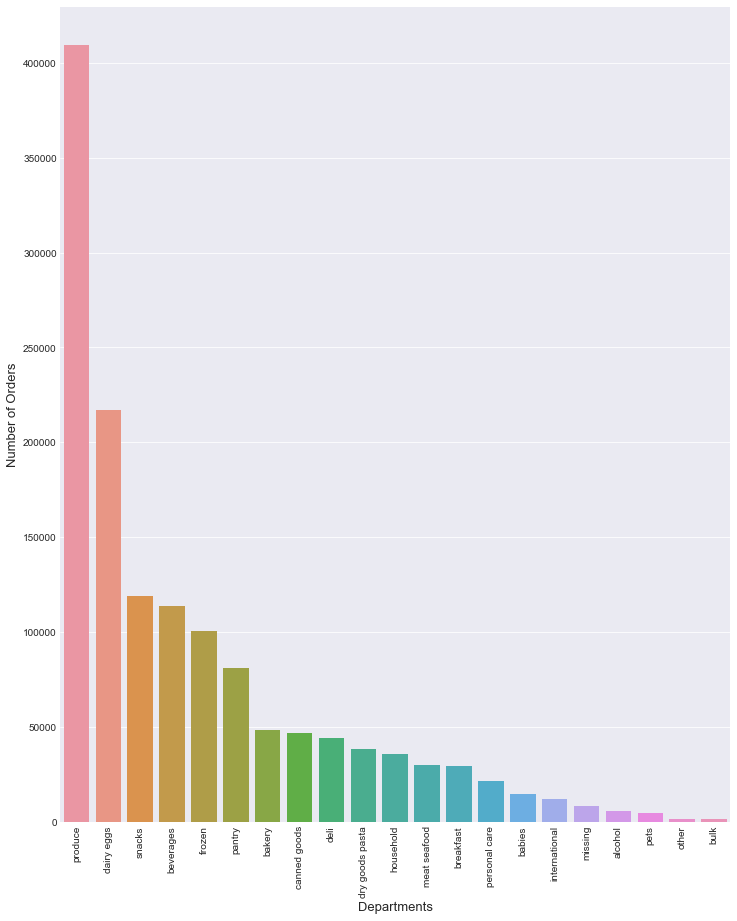

In [31]:
grouped  = grouped.groupby(['department']).sum()['Total_orders'].sort_values(ascending=False)
f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

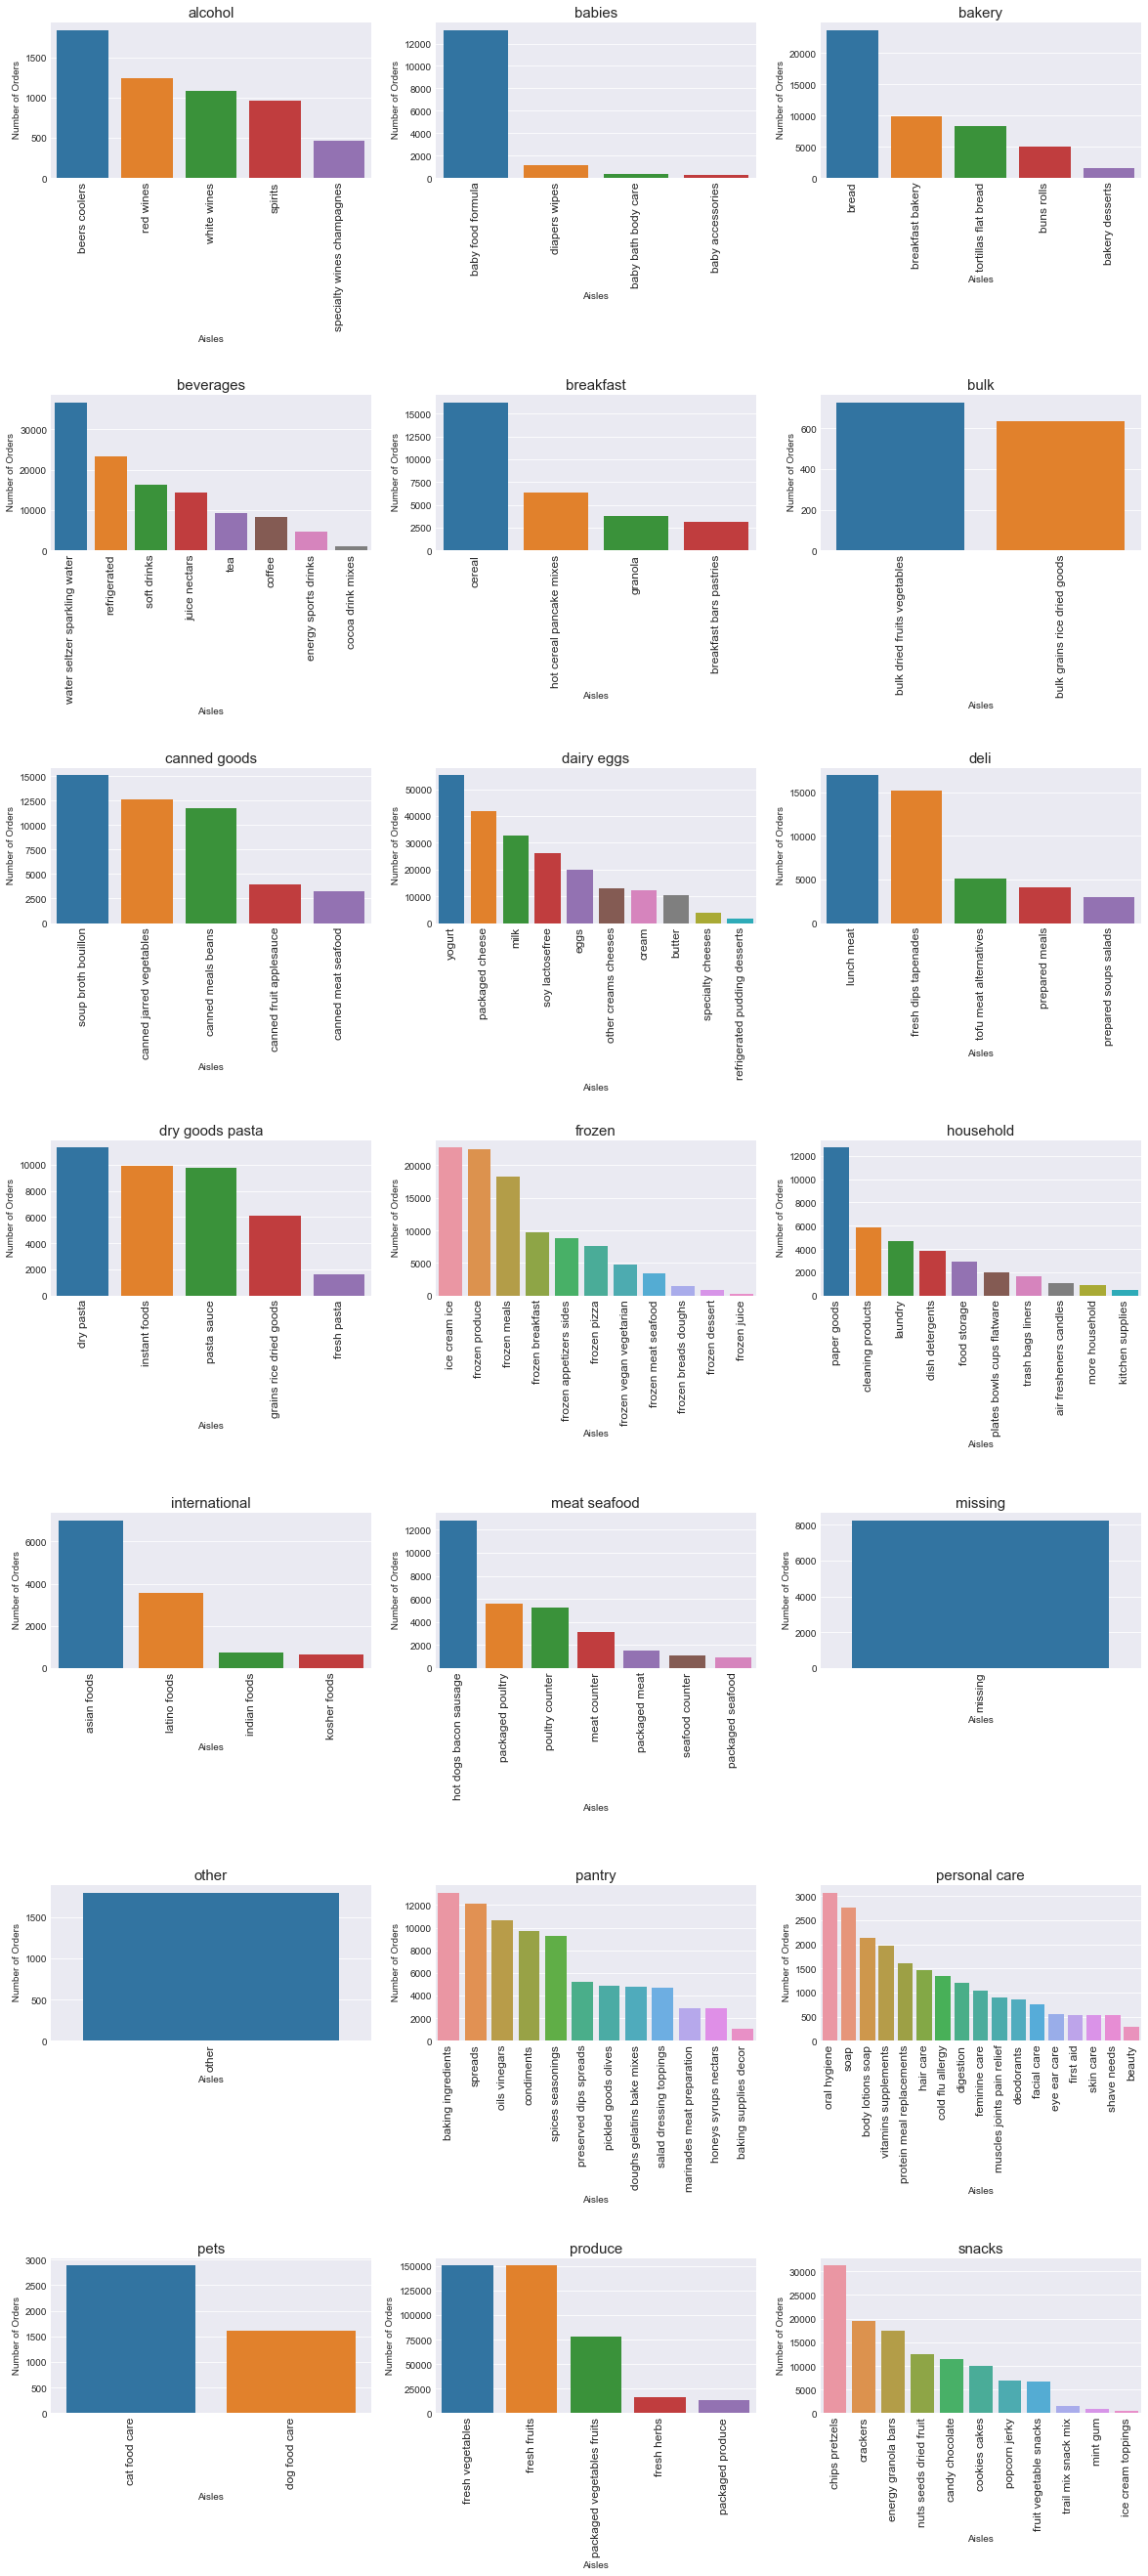

In [32]:
# the best selling aisles in each department (number of orders)

grouped=users_flow.groupby(["department","aisle"])["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)

fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_orders , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of Orders")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

In [33]:
# the best selling aisles over all departments
grouped = users_flow.groupby("aisle")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True )
grouped.head(10)

,aisle,Total_orders,Ratio
53,fresh vegetables,150609,0.1088
50,fresh fruits,150473,0.1087
98,packaged vegetables fruits,78493,0.0567
133,yogurt,55240,0.0399
93,packaged cheese,41699,0.0301
131,water seltzer sparkling water,36617,0.0264
83,milk,32644,0.0236
25,chips pretzels,31269,0.0226
119,soy lactosefree,26240,0.0190
11,bread,23635,0.0171


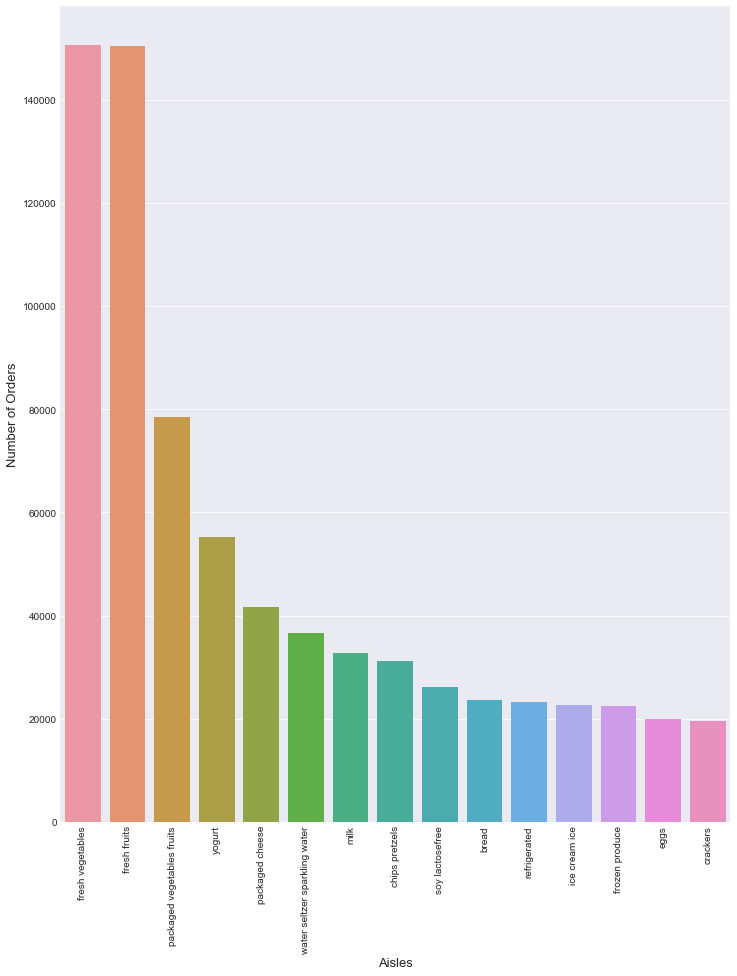

In [34]:
grouped  = grouped.groupby(['aisle']).sum()['Total_orders'].sort_values(ascending=False)[:15]
f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()

del items, grouped, users_flow

### 5. orders, products, order_products_prior, and departments

In [35]:
OPPsample = order_products_prior.sample(n=1000000)

merged = products.merge(OPPsample,on='product_id',how='inner')
merged = departments.merge(merged,on='department_id',how='inner')
merged = orders.merge(merged,on='order_id',how='inner')

Here I only took a 3,000,000 sample of individual product purchases.

Note: these purchases can come from any order so we won't have full orders in our set, this analysis is purely for individual purchase analysis. Now we continue by separating our big merged table into separate departmental tables.

In [36]:
department_list = list(departments.department)

department_data = {}
for n in department_list:
    d = merged.loc[merged['department']=='{0}'.format(n)]
    department_data['{0}'.format(n)] = d
    
list(department_data)

['frozen',
 'other',
 'bakery',
 'produce',
 'alcohol',
 'international',
 'beverages',
 'pets',
 'dry goods pasta',
 'bulk',
 'personal care',
 'meat seafood',
 'pantry',
 'breakfast',
 'canned goods',
 'dairy eggs',
 'household',
 'babies',
 'snacks',
 'deli',
 'missing']

We now create a dictionary for the first part of our analysis that looks at products by volume of purchases.

- Take each department table in our department_data dictionary, group it by product_name to get quantity purchased of each unique product
- clean it up

In [37]:
department_product_data = {}

for n in department_list:
    d = department_data['{0}'.format(n)].groupby(['product_name']).count().reset_index()
    department_product_data['{0}'.format(n)] = d
    department_product_data['{0}'.format(n)] = department_product_data['{0}'.format(n)].iloc[:,0:2]
    department_product_data['{0}'.format(n)].columns = ['product_name','quantity']
    department_product_data['{0}'.format(n)] = department_product_data['{0}'.format(n)].sort_values('quantity',ascending=False)
    department_product_data['{0}'.format(n)].reset_index(inplace=True)
    department_product_data['{0}'.format(n)] = department_product_data['{0}'.format(n)].iloc[:,1:4]
    
# sanity check random table in department_product_data
department_product_data['babies'].head()

,product_name,quantity
0,Baby Food Stage 2 Blueberry Pear & Purple Carrot,255
1,Spinach Peas & Pear Stage 2 Baby Food,229
2,Broccoli & Apple Stage 2 Baby Food,210
3,Gluten Free SpongeBob Spinach Littles,199
4,Kids Sensible Foods Broccoli Littles,189


For the next part of our analysis, we will look at how order_hour_of_day varies by purchases in each department.

In [38]:
# define the columns we are interested in from our big merged table and 
# make a new merged table with only those columns
time_columns = ['order_id','order_hour_of_day','department','product_name']
time_merged = pd.DataFrame(merged,columns=time_columns)
time_merged.head()

,order_id,order_hour_of_day,department,product_name
0,550135,9,snacks,Original Beef Jerky
1,738281,10,deli,Hommus Classic Original
2,738281,10,deli,Kalamata Olive Spread
3,1199898,9,dairy eggs,Total 2% with Strawberry Lowfat Greek Strained...
4,3194192,12,dairy eggs,Blueberry Yoghurt


Next we create a dictionary for the second part of our analysis called department_time_data in a similar manner

- group by order_hour_of_day to get quantity of products of ordered for each hour of the day
- clean it up

In [39]:
columns=['Order hour of day','Quantity'] 

department_time_data = {}
for n in department_list:
    d = time_merged.loc[time_merged['department']=='{0}'.format(n)] # Insert data from time_merged table into our new dictionary per each department
    department_time_data['{0}'.format(n)] = d
    department_time_data['{0}'.format(n)] = department_time_data['{0}'.format(n)].groupby('order_hour_of_day').count()
    department_time_data['{0}'.format(n)].reset_index(inplace=True)
    department_time_data['{0}'.format(n)] = department_time_data['{0}'.format(n)][department_time_data['{0}'.format(n)].columns[0:2]]
    department_time_data['{0}'.format(n)].columns = columns
    
# sanity check random table in department_time_data
department_time_data['alcohol'].head()

,Order hour of day,Quantity
0,0,17
1,1,14
2,2,6
3,3,3
4,4,6


Before we make the the days_since_reorder dictionary, we need to address the NaN values in that column. We can check the unique values in that column to make sure that all numbers 0-30 are accounted for before removing the NaN rows.

In [40]:
# check unique values in that column
orders['days_since_prior_order'].unique()

array([ nan,  15.,  21.,  29.,  28.,  19.,  20.,  14.,   0.,  30.,  10.,
         3.,   8.,  13.,  27.,   6.,   9.,  12.,   7.,  17.,  11.,  22.,
         4.,   5.,   2.,  23.,  26.,  25.,  16.,   1.,  18.,  24.])

In [41]:
orders = orders.dropna()

Next, let's only take columns that we need for this analysis and put that data into a new table called reorder_merged

In [42]:
reorder_columns = ['order_id','product_id','days_since_prior_order','department']
reorder_merged = pd.DataFrame(merged,columns=reorder_columns)

Now lets do the same thing for the reorder analysis that we did for the previous variables. This time grouping by days_since_prior_order which will give us the quantity of purchases that had an order_id with the same days_since_prior_order value. This one is quite a bit trickier to explain:

That is to say that our result will NOT represent the days since prior order for that specific product, rather it will represent the days since prior order for a specific USER's last order that ordered an item in their current order from that specified department.

In [43]:
columns2 = ['Days since prior order','Quantity'] 

department_reorder_data = {}
for n in department_list:
    d = reorder_merged.loc[reorder_merged['department']=='{0}'.format(n)]
    department_reorder_data['{0}'.format(n)] = d
    department_reorder_data['{0}'.format(n)] = department_reorder_data['{0}'.format(n)].groupby('days_since_prior_order').count()
    department_reorder_data['{0}'.format(n)].reset_index(inplace=True)
    department_reorder_data['{0}'.format(n)] = department_reorder_data['{0}'.format(n)][department_reorder_data['{0}'.format(n)].columns[0:2]]
    department_reorder_data['{0}'.format(n)].columns = columns2
    
# sanity check table in department_reorder_data
department_reorder_data['produce'].head()

,Days since prior order,Quantity
0,0.0,3728
1,1.0,8202
2,2.0,13675
3,3.0,17597
4,4.0,19506


Now that we have all of our data in the right format for all three modes of analysis, lets look at the first one:

- quantity of products purchased

We'll start by defining a function that plots the top ten products given a specific department

In [44]:
def toptenplot(name):
    p = sns.cubehelix_palette(10, start=0.6,dark=0.5, rot=1,light=0.8,reverse=True)
    plot = sns.barplot(palette = p,y='product_name',x='quantity',data=department_product_data['{0}'.format(name)].head(n=10))
    plot.set(xlabel='Quantity',ylabel='Product Name')

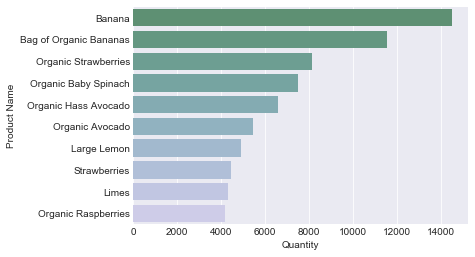

In [45]:
toptenplot('produce')

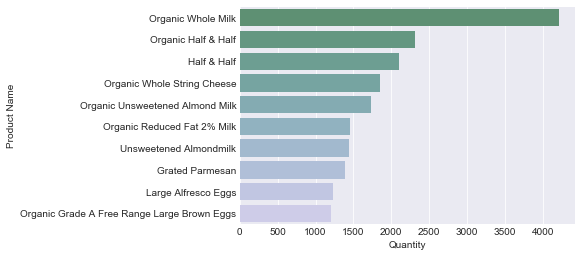

In [46]:
toptenplot('dairy eggs')

Now for the second part of our analysis:

- hour of day that products are purchased

Let's just stack all of the department tables in the department_time_data dictionary onto one line graph and see what we get.

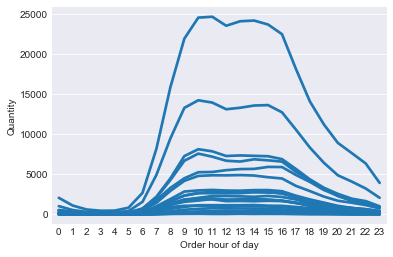

In [47]:
for n in department_list:
    sns.pointplot(x='Order hour of day',y='Quantity',data=department_time_data['{0}'.format(n)],markers=''
                  ,linestyles='-')

Lets normalize that to better compare the data to each other.

In [48]:
department_time_norm = {}

for n in department_list:
    #calculate normalized quantity
    q = department_time_data['{0}'.format(n)]['Quantity']
    q_norm = (q-q.mean())/(q.max()-q.min())
    
    #copy "department_time_data" to "department_time_norm"
    d = department_time_data['{0}'.format(n)]
    department_time_norm['{0}'.format(n)] = d
    
    #replace the quantity with our new normalized quantity "q_norm"
    department_time_norm['{0}'.format(n)]['Quantity']=q_norm

Okay lets set up our plot again. I've already colored the interesting ones.

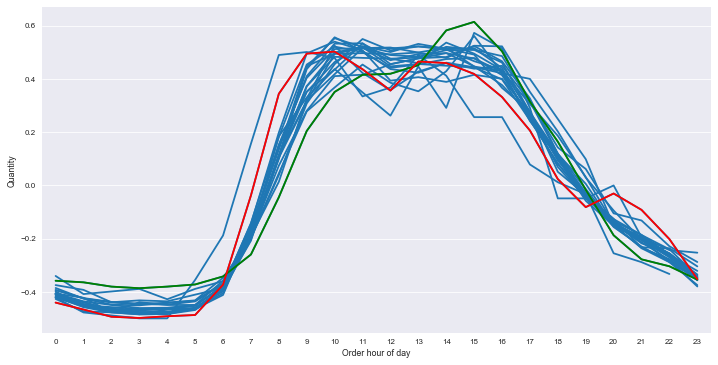

In [49]:
paper_rc = {'lines.linewidth': 1}                  
sns.set_context("paper", rc = paper_rc)
plt.figure(figsize=(12, 6))
plt.ylabel('Normalized Quantity')

for n in department_list: 
    sns.pointplot(x='Order hour of day',y='Quantity',data=department_time_norm['{0}'.format(n)],markers='',linestyles='-')

sns.pointplot(x='Order hour of day',y='Quantity',data=department_time_norm['alcohol'],markers='',linestyles='-',color='g')
sns.pointplot(x='Order hour of day',y='Quantity',data=department_time_norm['babies'],markers='',linestyles='-',color='r')

So there isn't a big significant difference accross the departments. In general it seems that most of the purchasing happens between 9pm and 4pm. There are two slight purchasing peaks at both ends of that timeframe, one around 9-10am and another around 3-4pm. It looks like for most departments, the first peak(9-10am) is greater than the second peak(3-4pm) except for the alcohol department. Lets look at the two departments that are colored
:babies_in_red and alcohol_in_green.

The alcohol department seems to be most popular during the late night and early morning (12am - 6am) and early afternoon (1pm - 3pm) and least popular between 6am - 10am and 7pm - 11pm.

The babies department is highest in relative quantity purchased in the early morning (6am-9am) hours and late night hours (8pm-10pm) and dips the lowest in the middle of the day around 12pm and is also the relative lowest popular department between midnight and 5am. The babies department also has relatively high variation throughout the day compared to the other departments

Note: To clarify what this graph truly represents, the order_hour_of_day isn't specifically for that individual product. Since the order_hour_of_day is linked to the order_id, the x axis of this graph represents order_hour_of_day for the order_id that contained these individual product purchases

Now onto the third part of our analysis:

- days since reorder

Lets start by learning from the past and normalizing the quantity column so we can compare departments to each other on a single graph.

In [50]:
department_reorder_norm = {}

for n in department_list:
    # calculate normalized quantity
    q = department_reorder_data['{0}'.format(n)]['Quantity']
    q_norm = (q-q.mean())/(q.max()-q.min())
    
    # copy "department_data" to "department_data_norm"
    d = department_reorder_data['{0}'.format(n)]
    department_reorder_norm['{0}'.format(n)] = d
    
    # replace the quantity with our new normalized quantity "q_norm"
    department_reorder_norm['{0}'.format(n)]['Quantity']=q_norm
    
# check random department
department_reorder_norm['produce'].head()

,Days since prior order,Quantity
0,0.0,-0.1658
1,1.0,-0.0212
2,2.0,0.1556
3,3.0,0.2824
4,4.0,0.3441


Let's set our plot up again by overlaying each department. Again, I've colored the interesting ones.

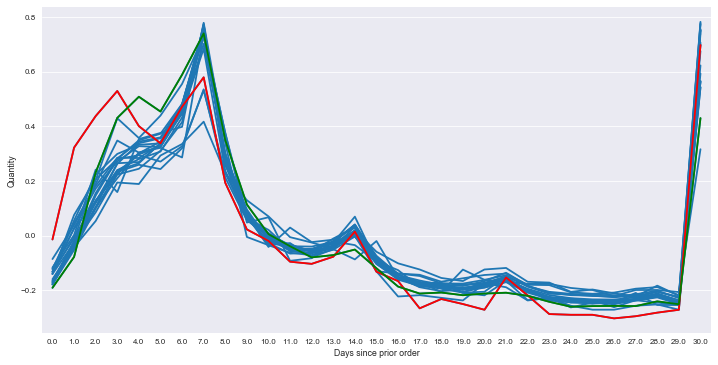

In [51]:
paper_rc = {'lines.linewidth': 1}                  
sns.set_context("paper", rc = paper_rc)
plt.figure(figsize=(12, 6))
plt.ylabel('Normalized Quantity')

for n in department_list:
    sns.pointplot(x='Days since prior order',y='Quantity',data=department_reorder_norm['{0}'.format(n)],markers='',linestyles='-')
    
sns.pointplot(x='Days since prior order',y='Quantity',data=department_reorder_norm['alcohol'],markers='',linestyles='-',color = 'r')
sns.pointplot(x='Days since prior order',y='Quantity',data=department_reorder_norm['babies'],markers='',linestyles='-',color = 'g')

del OPPsample, merged, department_product_data, time_merged, department_time_data
del reorder_merged, department_reorder_data, department_time_norm, department_reorder_norm

As in the previous analysis, these insights are consistent across different 3,000,000 samples:

- spike at 30 is due to the fact that the days_since_prior_order column maximum value is 30. so the quantity values at 30 days since prior order include purchases made greater than 30 days since prior order
-  we see spikes at 7, 14, and 21 indicating a tendency to reorder products weekly, biweekly, and triweekly.

Look who it is again, alcohol and babies.

- Of all the departments, the alcohol department has the highest normalized quantity of purchases that are reordered within the 0-3 day range
- the same applies to the babies department within the 4-6 day range
- the alcohol department purchase quantity is generally the lowest past the one week mark of days since reorder
- babies need diapers and other baby stuff. a lot of diapers and other baby stuff. This could explain the relative maximum reorder rate of the baby department between the 4-6 day period.

### 6. Customer Segments with PCA

In [52]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Here I will try to find a possible customer segmenetation enabling to classify customers according the their different purchases. Since there are thousands of products in the dataset I will rely on aisles which represents categories of products. Even with aisles features will be too much so I will use Principal Component Analysis to find new dimensions along which clustering will be easier. I will then try to find possible explanations for the identified clusters.

In [53]:
order_prior = order_products_prior.sample(n=100000)
mt = pd.merge(order_prior,products, on = ['product_id','product_id'])
mt = pd.merge(mt,orders,on=['order_id','order_id'])
mt = pd.merge(mt,aisles,on=['aisle_id','aisle_id'])
print("Types of product (aisle):", len(mt['aisle'].unique()))
mt['aisle'].value_counts()[0:5]

Types of product (aisle): 134


fresh fruits                  10599
fresh vegetables               9898
packaged vegetables fruits     5017
yogurt                         4214
packaged cheese                2774
Name: aisle, dtype: int64

There are 134 types of product (aisle), and fresh fruits and fresh vegetables are the best selling goods.

I want to find a possible clusters among the different customers and substitute single user_id with the cluster to which they are assumed to belong. Hope this would eventually increase the next prediction model performance.

Ths first thing to do is creating a dataframe with all the purchases made by each user.

In [54]:
cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])
cust_prod .head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can then execute a Principal Component Analysis to the obtained dataframe. This will reduce the number of features from the number of aisles to 6, the numbr of principal components I have chosen.

In [55]:
pca = PCA(n_components=6)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5
0,-0.4139,1.7985,-0.0734,-0.0042,-0.0313,-0.0207
1,-0.1553,-0.1804,-0.0748,-0.0808,-0.0324,-0.0183
2,-0.1558,-0.1876,-0.0808,-0.0962,-0.0472,-0.0148
3,-0.1627,-0.1947,-0.0805,-0.0914,-0.0402,-0.0229
4,-0.1553,-0.1843,-0.0783,-0.0826,-0.0373,-0.0230


I haven plotted several pair of components looking for the one suitable, in my opinion, for a KMeans Clustering. I have chosen the (PC4,PC1) pair. Since each component is the projection of all the points of the original dataset I think each component is representative of the dataset.

(58575, 2)
        4       1
0 -0.0313  1.7985
1 -0.0324 -0.1804
2 -0.0472 -0.1876
3 -0.0402 -0.1947
4 -0.0373 -0.1843


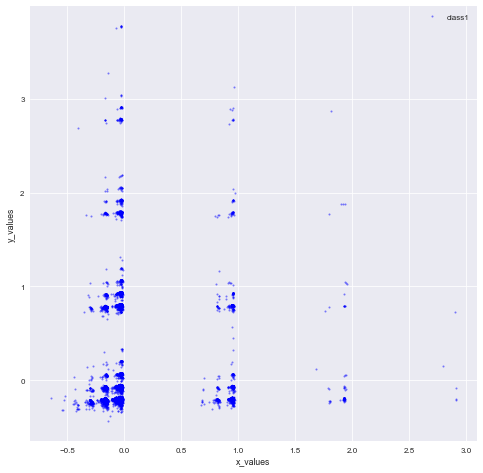

In [56]:
tocluster = pd.DataFrame(ps[[4,1]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[4], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [57]:
clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print("centers:")
print(centers)
print()
print ("c_preds:")
print(c_preds[0:100])

centers:
[[-0.04786939 -0.16689487]
 [-0.03341948  0.82273662]
 [ 0.97264902 -0.09636361]
 [ 0.02754652  1.95955647]]

c_preds:
[3 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 2 1 0 0 0 1 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 3 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0]


Here is how our clusters appear.

['green', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


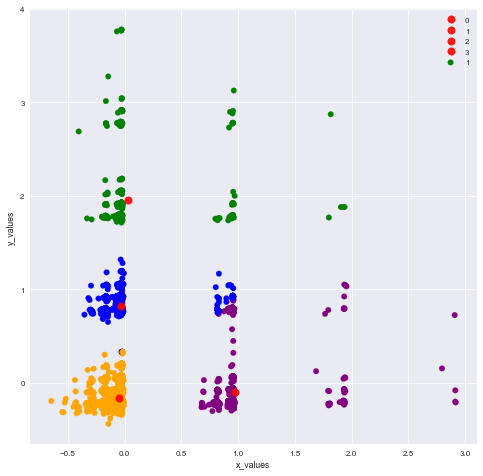

In [58]:
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])

plt.scatter(tocluster[4],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

We have found a possible clustering for our customers. Let's check if we also manage to find some interesting pattern beneath it.

In [59]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds
clust_prod.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(58575, 135)


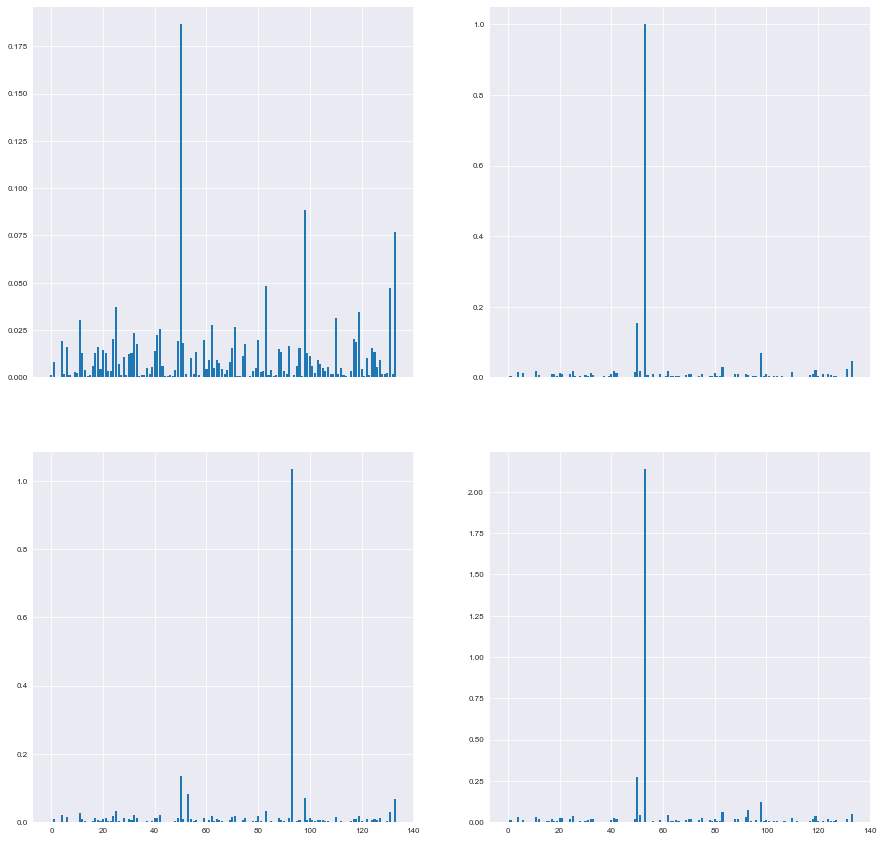

In [60]:
print (clust_prod.shape)
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))
c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)
c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)
plt.show()

Let's check out what are the top 10 goods bought by people of each cluster. We are going to rely first on the absolute data and then on a percentage among the top 8 products for each cluster.

In [61]:
print("c0:")
print(c0.sort_values(ascending=False)[0:5])
print()

print("c1:")
print(c1.sort_values(ascending=False)[0:5])
print()

print("c2:")
print(c2.sort_values(ascending=False)[0:5])
print()

print("c3:")
print(c3.sort_values(ascending=False)[0:5])

c0:
aisle
fresh fruits                     0.1865
packaged vegetables fruits       0.0884
yogurt                           0.0767
milk                             0.0485
water seltzer sparkling water    0.0471
dtype: float64

c1:
aisle
fresh vegetables              0.9997
fresh fruits                  0.1538
packaged vegetables fruits    0.0704
yogurt                        0.0465
milk                          0.0293
dtype: float64

c2:
aisle
packaged cheese               1.0334
fresh fruits                  0.1344
fresh vegetables              0.0835
packaged vegetables fruits    0.0703
yogurt                        0.0691
dtype: float64

c3:
aisle
fresh vegetables              2.1367
fresh fruits                  0.2709
packaged vegetables fruits    0.1232
packaged cheese               0.0727
milk                          0.0628
dtype: float64


A first analysis of the clusters confirm the initial hypothesis that:

- fresh fruits
- fresh vegetables
- packaged vegetables fruits
- yogurt
- packaged cheese
- milk
- water seltzer sparkling water
- chips pretzels

are products which are genereically bought by the majority of the customers.

What we can inspect here is if clusters differ in quantities and proportions, with respect of these goods, or if a cluster is characterized by some goods not included in this list. For instance we can already see cluster 3 is characterized by 'Baby Food Formula' product which is a significant difference with respect to the other clusters.

In [62]:
from IPython.display import display, HTML
cluster_means = [[c0['fresh fruits'],c0['fresh vegetables'],c0['packaged vegetables fruits'], c0['yogurt'], c0['packaged cheese'], c0['milk'],c0['water seltzer sparkling water'],c0['chips pretzels']],
                 [c1['fresh fruits'],c1['fresh vegetables'],c1['packaged vegetables fruits'], c1['yogurt'], c1['packaged cheese'], c1['milk'],c1['water seltzer sparkling water'],c1['chips pretzels']],
                 [c2['fresh fruits'],c2['fresh vegetables'],c2['packaged vegetables fruits'], c2['yogurt'], c2['packaged cheese'], c2['milk'],c2['water seltzer sparkling water'],c2['chips pretzels']],
                 [c3['fresh fruits'],c3['fresh vegetables'],c3['packaged vegetables fruits'], c3['yogurt'], c3['packaged cheese'], c3['milk'],c3['water seltzer sparkling water'],c3['chips pretzels']]]
cluster_means = pd.DataFrame(cluster_means, columns = ['fresh fruits','fresh vegetables','packaged vegetables fruits','yogurt','packaged cheese','milk','water seltzer sparkling water','chips pretzels'])
HTML(cluster_means.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,0.1865,0.0000,0.0884,0.0767,0.0000,0.0485,0.0471,0.0373
1,0.1538,0.9997,0.0704,0.0465,0.0068,0.0293,0.0234,0.0196
2,0.1344,0.0835,0.0703,0.0691,1.0334,0.0315,0.0307,0.0326
3,0.2709,2.1367,0.1232,0.0517,0.0727,0.0628,0.0197,0.0357


The following table depicts the percentage these goods with respect to the other top 8 in each cluster. It is easy some interesting differences among the clusters.

It seems people of cluster 1 buy more fresh vegetables than the other clusters. As shown by absolute data, Cluster 1 is also the cluster including those customers buying far more goods than any others.

People of cluster 2 buy more yogurt than people of the other clusters.

Absolute Data shows us People of cluster 3 buy a Lot of 'Baby Food Formula' which not even listed in the top 8 products but mainly characterize this cluster. Coherently (I think) with this observation they buy more milk than the others.

In [63]:
cluster_perc = cluster_means.iloc[:, :].apply(lambda x: (x / x.sum())*100,axis=1)
HTML(cluster_perc.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,38.4935,0.0000,18.2462,15.8343,0.0000,10.0144,9.7173,7.6943
1,11.3979,74.0727,5.2190,3.4483,0.5033,2.1715,1.7335,1.4539
2,9.0458,5.6209,4.7320,4.6536,69.5686,2.1176,2.0654,2.1961
3,9.7691,77.0426,4.4405,1.8650,2.6199,2.2647,0.7105,1.2877


I think another interesting information my come by lookig at the 10th to 15th most bought products for each cluster which will not include the generic products (i.e. vegetables, fruits, water, etc.) bought by anyone.

In [64]:
print("c0:")
print(c0.sort_values(ascending=False)[10:15])
print()

print("c1:")
print(c1.sort_values(ascending=False)[10:15])
print()

print("c2:")
print(c2.sort_values(ascending=False)[10:15])
print()

print("c3:")
print(c3.sort_values(ascending=False)[10:15])
print()

c0:
aisle
ice cream ice          0.0266
energy granola bars    0.0254
crackers               0.0236
eggs                   0.0223
cereal                 0.0202
dtype: float64

c1:
aisle
eggs                    0.0179
fresh herbs             0.0171
refrigerated            0.0165
baby food formula       0.0160
fresh dips tapenades    0.0141
dtype: float64

c2:
aisle
energy granola bars    0.0210
crackers               0.0206
lunch meat             0.0194
soy lactosefree        0.0183
frozen produce         0.0183
dtype: float64

c3:
aisle
bread                       0.0308
baby food formula           0.0296
other creams cheeses        0.0296
canned jarred vegetables    0.0283
refrigerated                0.0271
dtype: float64



In [65]:
del order_prior, mt, cust_prod, clust_prod

### 7. Non-Negative Matrix Factorization with Buyer

[Non-Negative Matrix Factorization][Non-Negative Matrix Factorization] has become a widely used tool for the analysis of high-dimensional data as it automatically extracts sparse and meaningful features from a set of nonnegative data vectors. 

[Non-Negative Matrix Factorization]:https://de.dariah.eu/tatom/topic_model_python.html

In [66]:
from scipy.sparse import csr_matrix
from collections import Counter
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from statsmodels import api 

In [67]:
test = orders[orders['eval_set']=='test']
prior = orders[orders['eval_set']=='prior']
test = pd.merge(test, prior[['user_id', 'order_id', 'order_number']], how = 'left', on = 'user_id')
test.head()

,order_id_x,user_id,eval_set,order_number_x,order_dow,order_hour_of_day,days_since_prior_order,order_id_y,order_number_y
0,2774568,3,test,13,5,15,11.0,444309,2
1,2774568,3,test,13,5,15,11.0,3002854,3
2,2774568,3,test,13,5,15,11.0,2037211,4
3,2774568,3,test,13,5,15,11.0,2710558,5
4,2774568,3,test,13,5,15,11.0,1972919,6


Merging with order history from order_prior table, but I am running a subset of the data below.

In [68]:
test = pd.merge(test[0:10000], order_products_prior, left_on = 'order_id_y', right_on = 'order_id')
test['new_order_id'] = test['order_id_x']
test['prior_order_id'] = test['order_id_y']
test = test.drop(['order_id_x', 'order_id_y'], axis = 1)
lookup_aisles = test.product_id.map(products.set_index('product_id')['department_id'])
test['aisles'] = lookup_aisles
test.head()

,user_id,eval_set,order_number_x,order_dow,order_hour_of_day,days_since_prior_order,order_number_y,order_id,product_id,add_to_cart_order,reordered,new_order_id,prior_order_id,aisles
0,3,test,13,5,15,11.0,2,444309,38596,1,0,2774568,444309,16
1,3,test,13,5,15,11.0,2,444309,21903,2,1,2774568,444309,4
2,3,test,13,5,15,11.0,2,444309,248,3,0,2774568,444309,19
3,3,test,13,5,15,11.0,2,444309,40604,4,0,2774568,444309,16
4,3,test,13,5,15,11.0,2,444309,8021,5,0,2774568,444309,17


In [69]:
product_list = test[test['reordered']==1].groupby(['user_id', 'order_number_x', 'new_order_id']). \
                agg({'product_id': lambda x: tuple(x),'aisles': lambda x: tuple(x)})
product_list = pd.DataFrame(product_list.reset_index())
product_list['num_products_reordered'] = product_list.product_id.apply(len)
product_list.head()

,user_id,order_number_x,new_order_id,product_id,aisles,num_products_reordered
0,3,13,2774568,"(21903, 17668, 32402, 39190, 47766, 21903, 938...","(4, 16, 19, 16, 4, 4, 4, 16, 4, 16, 4, 1, 20, ...",55
1,4,6,329954,"(35469,)","(1,)",1
2,6,4,1528013,"(38293, 21903)","(12, 4)",2
3,11,8,1376945,"(35640, 42585, 36070, 41290, 14947, 35948, 279...","(20, 20, 4, 7, 7, 7, 7, 15, 16, 20, 20, 17, 17...",33
4,12,6,1356845,"(10863, 7076, 20350, 13176, 14992, 21616, 8239...","(8, 8, 8, 4, 4, 4, 13, 16, 4, 4, 8, 8, 8)",13


In [70]:
# the output below shows what one user's order history looks like
test[(test['user_id'] == 3)].head()

,user_id,eval_set,order_number_x,order_dow,order_hour_of_day,days_since_prior_order,order_number_y,order_id,product_id,add_to_cart_order,reordered,new_order_id,prior_order_id,aisles
0,3,test,13,5,15,11.0,2,444309,38596,1,0,2774568,444309,16
1,3,test,13,5,15,11.0,2,444309,21903,2,1,2774568,444309,4
2,3,test,13,5,15,11.0,2,444309,248,3,0,2774568,444309,19
3,3,test,13,5,15,11.0,2,444309,40604,4,0,2774568,444309,16
4,3,test,13,5,15,11.0,2,444309,8021,5,0,2774568,444309,17


To create the users x products count table loop through the prodcut_ids data to as a sparse matrix (much more memory efficient), column position contains the product_ids with position listed in a dict.

In [71]:
indptr = [0]
indices = []
data = []
column_position = {}
# input must be a list of lists
for order in product_list['product_id']:
    for product in order:
        index = column_position.setdefault(product, len(column_position))
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))
    
prod_matrix = csr_matrix((data, indices, indptr), dtype=int)
prod_matrix.shape

(682, 6655)

The problem with using the sparse matrix is that it is gigantic, after all there are a lot of users and a lot of products. Non-negative matrix decomposition is implemented in sklearn, use that to decompose the count matrix into two new matrices with considerably reduced dimensions.

In [72]:
nmf = NMF(n_components = 10, init='random', random_state = 42)
model = nmf.fit(prod_matrix)
H = model.components_
model.components_.shape

(10, 6655)

What can I do with the results? For one, I could pick a random user and find users that have similar purchasing behavior.

In [73]:
W = model.transform(prod_matrix)
user_data = pd.DataFrame(normalize(W), index = product_list['user_id'])
idx = user_data.dot(user_data.iloc[0]).nlargest(5).index
user_data.dot(user_data.iloc[0]).nlargest(5)

user_id
3       1.0000
232     0.9980
221     0.9946
1092    0.9887
1288    0.9886
dtype: float64

In [74]:
def prod_count(product_ids):
    prod_count = {}
    for item in product_ids:
        if item not in prod_count.keys():
            prod_count[item] = 1
        elif item in prod_count.keys():
            prod_count[item] += 1
    return prod_count

similar_users = product_list[product_list.user_id.isin(idx)]
similar_users

,user_id,order_number_x,new_order_id,product_id,aisles,num_products_reordered
0,3,13,2774568,"(21903, 17668, 32402, 39190, 47766, 21903, 938...","(4, 16, 19, 16, 4, 4, 4, 16, 4, 16, 4, 1, 20, ...",55
75,221,24,2088686,"(5479, 27531, 14161, 23236, 14161, 27531, 2983...","(7, 16, 4, 1, 4, 16, 1, 4, 1, 4, 16, 1, 1, 1, ...",168
79,232,37,795256,"(8193, 10761, 30489, 8859, 10761, 45, 10761, 8...","(4, 16, 20, 7, 16, 4, 16, 7, 4, 4, 13, 12, 4, ...",351
376,1092,9,2933690,"(47766, 47144, 4410, 47144, 4410, 10644, 47766...","(4, 16, 14, 16, 14, 13, 4, 4, 16, 4, 14, 4, 19...",34
451,1288,9,1334507,"(30183, 31683, 15860, 26924, 14576, 29675, 301...","(14, 7, 15, 7, 1, 4, 14, 7, 7, 1, 15, 16, 4, 1...",94


In [75]:
overlap = set(similar_users.product_id.iloc[0]) & set(similar_users.product_id.iloc[2])
overlap

{22035}

Here are order counts.

In [76]:
counts = similar_users.product_id.apply(prod_count)

def id_values(row, overlap):
    for key, value in row.items():
        if key in overlap:
            print(key, value)
            
id_values(counts.iloc[0], overlap)

22035 2


Another benefit is that the W matrix contains latent information regarding the amount of each item a user has ordered in the past, but has vastly reduced dimensions. In other words, it doesn't keep each product as a column of the original user x product count matrix.

Using multi-nomial logistic regression with aisles instead of products to see if the W matrix columns have an impact, some of the p-values do look significant. Aisles represents a group of products and reduces the classes of the dependent variable but has a strong relationship to the products.

In [77]:
df = pd.concat([product_list.user_id, pd.DataFrame(W)], axis = 1)
df = pd.merge(test[0:10000], df, how = 'left').drop('eval_set', axis = 1)

x = df.iloc[:, 12:]
y = df.reordered.values

x = api.add_constant(x, prepend = False)
mn_log = api.MNLogit(y, x)
model = mn_log.fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.657742
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                        MNLogit   Df Residuals:                     9988
Method:                           MLE   Df Model:                           11
Date:                Tue, 26 Sep 2017   Pseudo R-squ.:                 0.03825
Time:                        16:11:47   Log-Likelihood:                -6577.4
converged:                       True   LL-Null:                       -6839.0
                                        LLR p-value:                3.737e-105
==============================================================================
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
aisles        -0.0143      0.003     -4.217      0.000      -0.021      -0.008
0             -0.3548      0.611     -0.581      0.561      -1.552       0.842
1              0.2973      0.088      3.371      0.001       0.124       0.470
2              0.7544      2.369      0.318      0.750      -3.889       5.398
3             14.5798      1.403     10.393      0.000      11.830      17.329
4             12.2361      2.818      4.342      0.000       6.712      17.760
5              7.5589      2.273      3.325      0.001       3.103      12.015
6             -5.1467      0.875     -5.880      0.000      -6.862      -3.431
7              2.2183      0.603      3.676      0.000       1.036       3.401
8              9.3025      4.508      2.064      0.039       0.468      18.138
9              7.0579      0.808      8.738      0.000       5.475       8.641
const         -0.1748      0.050     -3.489      0.000      -0.273      -0.077
==============================================================================
"""

In [78]:
del test, df

### 8. F1-Score, Precision and Recall

After you have created a prediction on your test set, we need to calculate the F1-score for each row and the total dataset. For this we need to get the precision and recall for each row. These can be a bit confusing though at first.

- precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances
- recall (also known as sensitivity) is the fraction of relevant instances that have been retrieved over total relevant instances

The F1-Score combines these two and gives a good score if you predict the right instances and the right amount of instances.

Example: Let's say a customer actually bought 10 products (IDs are 0-9). Our model predicts 5 products (IDs 7, 8, 9, 10, 11) out of which 3 are correct (IDs 7, 8, 9) and 2 are incorrect.

- precision is 3/5
- recall is 3/10

Instead of just rating your prediction on how many correct products you got, the F1-Score is penalizing predictions with too many false positives. Suppose we had 100 products in the whole inventory and we predicted that each customer bought all 100 of them, we would predict all the actually bought products but all the additional false positives would keep the score down.

In [79]:
cv_labels_df = pd.read_csv('datasets/sample_submission.csv')
cv_labels_df['products'] = cv_labels_df['products'].astype(str)

cv_preds_df = pd.read_csv('datasets/sample_submission.csv')
cv_preds_df['products'] = cv_preds_df['products'].astype(str)

cv_labels_df = pd.merge(cv_labels_df, cv_preds_df, how='left', on='order_id')

In [80]:
def eval_fun(labels, preds):
    labels = labels.split(' ')
    preds = preds.split(' ')
    rr = (np.intersect1d(labels, preds))
    precision = np.float(len(rr)) / len(preds)
    recall = np.float(len(rr)) / len(labels)
    try:
        f1 = 2 * precision * recall / (precision + recall)
    except ZeroDivisionError:
        return (precision, recall, 0.0)
    return (precision, recall, f1)

In [81]:
res = list()
for entry in cv_labels_df.itertuples():
    res.append(eval_fun(entry[2], entry[3]))
    
res = pd.DataFrame(np.array(res), columns=['precision', 'recall', 'f1'])
res.describe()

,precision,recall,f1
count,75000.0,75000.0,75000.0
mean,1.0,1.0,1.0
std,0.0,0.0,0.0
min,1.0,1.0,1.0
25%,1.0,1.0,1.0
50%,1.0,1.0,1.0
75%,1.0,1.0,1.0
max,1.0,1.0,1.0


## Model Building

In [82]:
import gc
import time
import xgboost
from sklearn.model_selection import train_test_split

### 1. Data Preprocess

In [83]:
priors = order_products_prior.sample(n=3000000)
train = order_products_train
orders = orders.sample(n=300000)

In [84]:
class tick_tock:
    def __init__(self, process_name, verbose=1):
        self.process_name = process_name
        self.verbose = verbose
    def __enter__(self):
        if self.verbose:
            print(self.process_name + " begin ......")
            self.begin_time = time.time()
    def __exit__(self, type, value, traceback):
        if self.verbose:
            end_time = time.time()
            print(self.process_name + " end ......")
            print('time lapsing {0} s \n'.format(end_time - self.begin_time))

In [85]:
def ka_add_groupby_features_1_vs_n(df, group_columns_list, agg_dict, only_new_feature=True):
    '''Create statistical columns, group by [N columns] and compute stats on [N column]

       Parameters
       ----------
       df: pandas dataframe
          Features matrix
       group_columns_list: list_like
          List of columns you want to group with, could be multiple columns
       agg_dict: python dictionary

       Return
       ------
       new pandas dataframe with original columns and new added columns

       Example
       -------
       {real_column_name: {your_specified_new_column_name : method}}
       agg_dict = {'user_id':{'prod_tot_cnts':'count'},
                   'reordered':{'reorder_tot_cnts_of_this_prod':'sum'},
                   'user_buy_product_times': {'prod_order_once':lambda x: sum(x==1),
                                              'prod_order_more_than_once':lambda x: sum(x==2)}}
       ka_add_stats_features_1_vs_n(train, ['product_id'], agg_dict)
    '''
    with tick_tock("add stats features"):
        try:
            if type(group_columns_list) == list:
                pass
            else:
                raise TypeError(k + "should be a list")
        except TypeError as e:
            print(e)
            raise

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped.agg(agg_dict)
        the_stats.columns = the_stats.columns.droplevel(0)
        the_stats.reset_index(inplace=True)
        if only_new_feature:
            df_new = the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')

    return df_new

In [86]:
def ka_add_groupby_features_n_vs_1(df, group_columns_list, target_columns_list, methods_list, keep_only_stats=True, verbose=1):
    '''Create statistical columns, group by [N columns] and compute stats on [1 column]

       Parameters
       ----------
       df: pandas dataframe
          Features matrix
       group_columns_list: list_like
          List of columns you want to group with, could be multiple columns
       target_columns_list: list_like
          column you want to compute stats, need to be a list with only one element
       methods_list: list_like
          methods that you want to use, all methods that supported by groupby in Pandas

       Return
       ------
       new pandas dataframe with original columns and new added columns

       Example
       -------
       ka_add_stats_features_n_vs_1(train, group_columns_list=['x0'], target_columns_list=['x10'])
    '''
    with tick_tock("add stats features", verbose):
        dicts = {"group_columns_list": group_columns_list , "target_columns_list": target_columns_list, "methods_list" :methods_list}

        for k, v in dicts.items():
            try:
                if type(v) == list:
                    pass
                else:
                    raise TypeError(k + "should be a list")
            except TypeError as e:
                print(e)
                raise

        grouped_name = ''.join(group_columns_list)
        target_name = ''.join(target_columns_list)
        combine_name = [[grouped_name] + [method_name] + [target_name] for method_name in methods_list]

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped[target_name].agg(methods_list).reset_index()
        the_stats.columns = [grouped_name] + \
                            ['_%s_%s_by_%s' % (grouped_name, method_name, target_name) \
                             for (grouped_name, method_name, target_name) in combine_name]
        if keep_only_stats:
            return the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')
        return df_new

#### $\star$ Product part

In [87]:
priors_orders_detail = orders.merge(right=priors, how='inner', on='order_id')

priors_orders_detail.loc[:,'_user_buy_product_times'] = \
                 priors_orders_detail.groupby(['user_id', 'product_id']).cumcount() + 1

agg_dict = {'user_id':{'_prod_tot_cnts':'count'}, 
                 'reordered':{'_prod_reorder_tot_cnts':'sum'}, 
                 '_user_buy_product_times': {'_prod_buy_first_time_total_cnt':lambda x: sum(x==1),
                                            '_prod_buy_second_time_total_cnt':lambda x: sum(x==2)}}

prd = ka_add_groupby_features_1_vs_n(priors_orders_detail, ['product_id'], agg_dict)

add stats features begin ......
add stats features end ......
time lapsing 9.516016721725464 s 



In [88]:
prd['_prod_reorder_prob'] = prd._prod_buy_second_time_total_cnt / prd._prod_buy_first_time_total_cnt
prd['_prod_reorder_ratio'] = prd._prod_reorder_tot_cnts / prd._prod_tot_cnts
prd['_prod_reorder_times'] = 1 + prd._prod_reorder_tot_cnts / prd._prod_buy_first_time_total_cnt
prd.head()

,product_id,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_buy_first_time_total_cnt,_prod_buy_second_time_total_cnt,_prod_reorder_prob,_prod_reorder_ratio,_prod_reorder_times
0,1,19,15,19,0,0.0,0.7895,1.7895
1,3,3,3,2,1,0.5,1.0000,2.5000
2,4,4,1,4,0,0.0,0.2500,1.2500
3,9,1,1,1,0,0.0,1.0000,2.0000
4,10,16,11,16,0,0.0,0.6875,1.6875


#### $\star$ User Part

In [89]:
agg_dict_2 = {'order_number':{'_user_total_orders':'max'},
                  'days_since_prior_order':{'_user_sum_days_since_prior_order':'sum', 
                                            '_user_mean_days_since_prior_order': 'mean'}}

users = ka_add_groupby_features_1_vs_n(orders[orders.eval_set == 'prior'], ['user_id'], agg_dict_2)

add stats features begin ......
add stats features end ......
time lapsing 0.12480020523071289 s 



In [90]:
agg_dict_3 = {'reordered':
                  {'_user_reorder_ratio': 
                   lambda x: sum(priors_orders_detail.loc[x.index,'reordered']==1)/
                             sum(priors_orders_detail.loc[x.index,'order_number'] > 1)},
                  'product_id':{'_user_total_products':'count', 
                             '_user_distinct_products': lambda x: x.nunique()}}

us = ka_add_groupby_features_1_vs_n(priors_orders_detail, ['user_id'], agg_dict_3)

users = users.merge(us, how='inner')

add stats features begin ......
add stats features end ......
time lapsing 104.4265832901001 s 



In [91]:
users['_user_average_basket'] = users._user_total_products / users._user_total_orders
us = orders[orders.eval_set != "prior"][['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
us.rename(index=str, columns={'days_since_prior_order': 'time_since_last_order'}, inplace=True)
users = users.merge(us, how='inner')
users.head()

,user_id,_user_total_orders,_user_sum_days_since_prior_order,_user_mean_days_since_prior_order,_user_reorder_ratio,_user_total_products,_user_distinct_products,_user_average_basket,order_id,eval_set,time_since_last_order
0,42,9,24.0,24.0,1.0,2,2,0.2222,2803975,train,14.0
1,77,12,6.0,6.0,1.0,2,2,0.1667,2681168,test,28.0
2,89,14,11.0,5.5,1.0,3,3,0.2143,2222431,train,6.0
3,109,4,20.0,20.0,1.0,1,1,0.2500,1997693,train,21.0
4,119,3,17.0,17.0,0.5,2,2,0.6667,461193,train,30.0


#### $\star$ Database Part

In [92]:
agg_dict_4 = {'order_number':{'_up_order_count': 'count', 
                              '_up_first_order_number': 'min', 
                              '_up_last_order_number':'max'}, 
               'add_to_cart_order':{'_up_average_cart_position': 'mean'}}

data = ka_add_groupby_features_1_vs_n(df=priors_orders_detail, 
                                        group_columns_list=['user_id', 'product_id'], 
                                        agg_dict=agg_dict_4)

data = data.merge(prd, how='inner', on='product_id').merge(users, how='inner', on='user_id')

data['_up_order_rate'] = data._up_order_count / data._user_total_orders
data['_up_order_since_last_order'] = data._user_total_orders - data._up_last_order_number
data['_up_order_rate_since_first_order'] = \
                data._up_order_count / (data._user_total_orders - data._up_first_order_number + 1)

add stats features begin ......
add stats features end ......
time lapsing 0.2652006149291992 s 



In [93]:
# add user_id to train set
train = train.merge(right=orders[['order_id', 'user_id']], how='left', on='order_id')
data = data.merge(train[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')
data.head()

,user_id,product_id,_up_order_count,_up_first_order_number,_up_last_order_number,_up_average_cart_position,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_buy_first_time_total_cnt,_prod_buy_second_time_total_cnt,...,_user_total_products,_user_distinct_products,_user_average_basket,order_id,eval_set,time_since_last_order,_up_order_rate,_up_order_since_last_order,_up_order_rate_since_first_order,reordered
0,61005,47526,1,14,14,3.0,44,26,44,0,...,13,12,0.2407,1938356,train,3.0,0.0185,40,0.0244,NaN
1,61005,21137,1,54,54,2.0,2194,1854,2080,106,...,13,12,0.2407,1938356,train,3.0,0.0185,0,1.0000,1.0
2,61005,13176,1,34,34,4.0,3015,2674,2840,168,...,13,12,0.2407,1938356,train,3.0,0.0185,20,0.0476,NaN
3,61005,47672,1,34,34,3.0,178,123,174,4,...,13,12,0.2407,1938356,train,3.0,0.0185,20,0.0476,NaN
4,61005,27344,1,37,37,2.0,348,254,337,10,...,13,12,0.2407,1938356,train,3.0,0.0185,17,0.0556,NaN


### 2. XGboost Model

In [94]:
train = data.loc[data.eval_set == "train",:]
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
train.loc[:, 'reordered'] = train.reordered.fillna(0)

X_test = data.loc[data.eval_set == "test",:]
X_train, X_val, y_train, y_val = train_test_split(train.drop('reordered', axis=1), train.reordered,
                                 test_size=0.9, random_state=42)

[0]	train-logloss:0.660013
[20]	train-logloss:0.458872
[40]	train-logloss:0.416196
[60]	train-logloss:0.390733
[80]	train-logloss:0.369599
[99]	train-logloss:0.354751


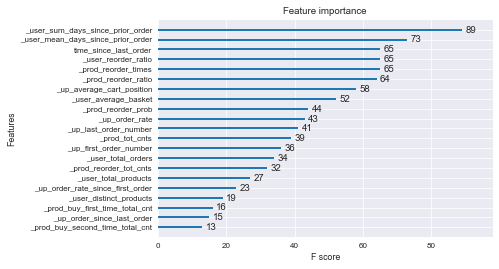

In [95]:
d_train = xgboost.DMatrix(X_train, y_train)
d_test = xgboost.DMatrix(X_test.drop(['eval_set', 'user_id', 'order_id', 'reordered', 'product_id'], axis=1))

xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
    }

watchlist= [(d_train, "train")]

bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=100, evals=watchlist, verbose_eval=20)

xgboost.plot_importance(bst)

In [96]:
X_test.loc[:,'reordered'] = (bst.predict(d_test) > 0.21).astype(int)
X_test.loc[:, 'product_id'] = X_test.product_id.astype(str)

result = ka_add_groupby_features_n_vs_1(X_test[X_test.reordered == 1], 
                                               group_columns_list=['order_id'],
                                               target_columns_list= ['product_id'],
                                               methods_list=[lambda x: ' '.join(set(x))], keep_only_stats=True)

sample_submission = pd.read_csv("datasets/sample_submission.csv")
result.columns = sample_submission.columns.tolist()
final_result = sample_submission[['order_id']].merge(result, how='left').fillna('None')
final_result[final_result.products != 'None'].head()

add stats features begin ......
add stats features end ......
time lapsing 0.031199932098388672 s 



,order_id,products
37,2070,47144
82,4551,49683
123,6718,13225
125,6763,20995
161,8326,28427
